# Analyzing Ithaca's Gorge Stewarding Program

##  Import and Setup

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install hdbscan

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
import string
from nltk import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
gorges = pd.read_csv("/content/gorges.csv")
gorges = gorges.iloc[:, :-12]
gorges.loc[146, 'Date'] = "6/30/2022"
gorges.loc[215, 'Date'] = "5/28/2021"
gorges.loc[509, 'Date'] = "6/5/2019"
gorges.loc[529, 'Date'] = "6/19/2019"
gorges.loc[558, 'Date'] = "7/3/2019"
gorges.loc[589, 'Date'] = "7/17/2019"
gorges.loc[599, 'Date'] = "7/22/2019"
gorges.loc[620, 'Date'] = "7/31/2019"
gorges.loc[649, 'Date'] = "8/14/2019"
gorges.loc[669, 'Date'] = "8/28/2019"
gorges.loc[667, 'Date'] = "8/28/2019"

# convert date into a date object
gorges['Date'] = pd.to_datetime(gorges['Date'])

print(len(gorges))
gorges.head()


1107


,Date,Patrol Time,Steward name,High Temperature,Weather,Number of observed gorge users,total Number of people obseved violating a rule,Number of person interactions: Alternatives,Number of person interactions: Warnings,Number of person interactions: Directions,Total number of person interactions (Daily),Number of contacts to CUPD,Number of People above Ithaca Falls?,Description of Interactions,Description of notable events
0,2023-05-25,11AM-7PM,Brenner,61,"sunny, windy",168,0,0.0,0.0,1.0,1.0,0,0,Someone asked about north campus,saw some geese babies!
1,2023-05-26,11AM-7PM,Brenner,68,"sunny, clear",264,0,0.0,0.0,9.0,9.0,0,0,lots of commencement direction questions,numerous grad photos
2,2023-05-27,11AM-7PM,Brenner,77,sunny,251,2,0.0,2.0,5.0,7.0,0,0,few people suntanning on rocks in the water,someone asked me where the slope was lol
3,2023-05-28,11-7PM,Phillip,81,Sunny,184,5,0.0,5.0,9.0,14.0,0,0,"Lots of people looking for arboretum, three do...",I saw a cool butterfly
4,2023-05-29,11-7PM,Phillip,85,Sunny,102,0,0.0,0.0,6.0,0.0,0,0,"Big day for tourists, small day for violators",Found boathouse key on Bebee lake trail. Is no...


In [ ]:
# extract out the observations column that aren't nan
interactions_df = gorges[gorges['Description of Interactions'].notna()]
interactions_df = interactions_df[interactions_df['Description of Interactions'] != '0']

# keep only non-na observations
observations_df = gorges[gorges['Description of notable events'].notna()]

#place all the interactions and observations into a dictionary (this is later uncased, but may be helpful)
log = {'interaction': [],'observation': []}

for i in range(len(interactions_df)):
    msg = {'index': i,
           'date': interactions_df.iloc[i, 0],
           "steward": interactions_df.iloc[i, 2],
           "msg": interactions_df.iloc[i, 13]}
    log['interaction'].append(msg)

for i in range(len(observations_df)):
    msg = {'index': i,
           'date': observations_df.iloc[i, 0],
           "steward": observations_df.iloc[i, 2],
           "msg": observations_df.iloc[i, 14]}
    log['observation'].append(msg)

# reassign dict to respective lists
interactions = log['interaction']
observations = log['observation']

print("Total Interactions:", len(log['interaction']))
print("First three interactions:")
for i in range(3):
  print(interactions[i])
print("")

print("Total Observations:", len(log['observation']))
print('First three observation texts:')
for i in range(220, 223):
  print(observations[i]['msg'])

Total Interactions: 354
First three interactions:
{'index': 0, 'date': Timestamp('2023-05-25 00:00:00'), 'steward': 'Brenner', 'msg': 'Someone asked about north campus'}
{'index': 1, 'date': Timestamp('2023-05-26 00:00:00'), 'steward': 'Brenner', 'msg': 'lots of commencement direction questions'}
{'index': 2, 'date': Timestamp('2023-05-27 00:00:00'), 'steward': 'Brenner', 'msg': 'few people suntanning on rocks in the water'}

Total Observations: 223
First three observation texts:
Lots's of ppl outside walking after classes let out this PM. Love to see it!
nothing notable happened today.
lots of poeple all over! great last day. Hope to continue again next summer!


## Exploratory Data Analysis and Statistics

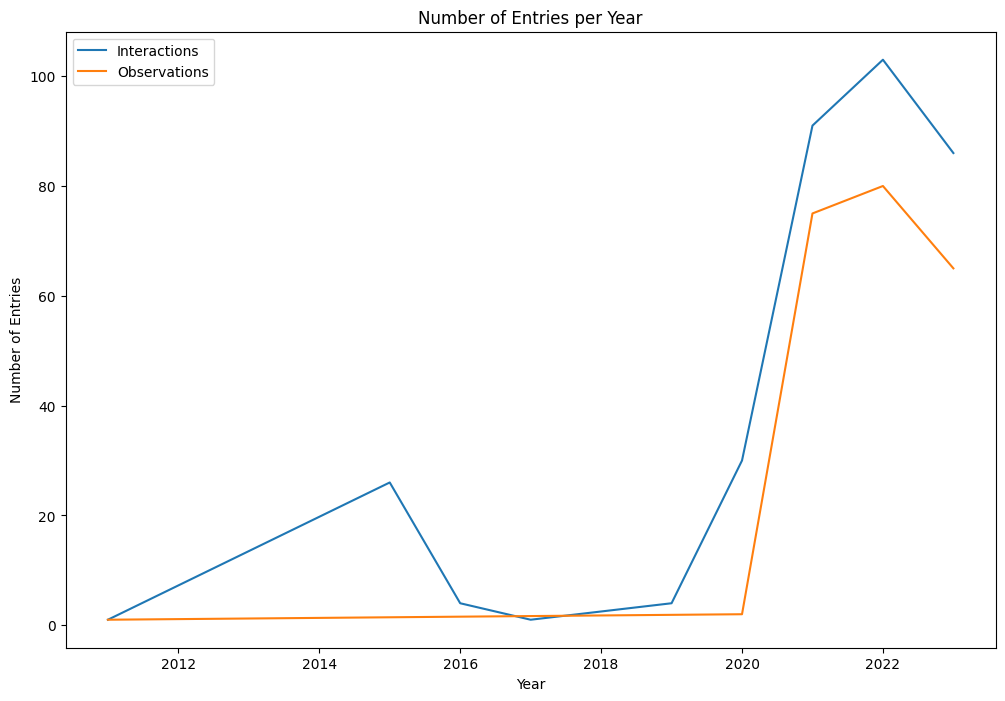

In [ ]:
# amount of rows per year

num_inter = interactions_df.groupby('Date').size().groupby(lambda x: x.year).sum()
num_obsv = observations_df.groupby('Date').size().groupby(lambda x: x.year).sum()

# graph this out
plt.figure(figsize=(12, 8))
plt.plot(num_inter, label='Interactions')
plt.plot(num_obsv, label='Observations')
plt.xlabel('Year')
plt.ylabel('Number of Entries')
plt.title('Number of Entries per Year')
plt.legend()
plt.show()

In [ ]:
# return 20 most frequent words, not including stopwords

eng_stopwords = stopwords.words('english')
eng_stopwords.extend(string.punctuation)
eng_stopwords.extend(['lower'])

def word_stats(data, stopwords=eng_stopwords, n=20):
    if (stopwords != None):
        for stopword in stopwords:
            del data[stopword]

    print("Number of total tokens in text:", sum(data.values()))
    print("Number of unique words in interactions:", len(data.values()))
    print("Top", n, "most frequent words in text:")
    print(data.most_common(n))

words = []
for description in interactions_df['Description of Interactions']:
    words += nltk.word_tokenize(description)
inter_counter = Counter(words)

words = []
for description in observations_df['Description of notable events']:
    words += nltk.word_tokenize(description)
obsv_counter = Counter(words)

print(word_stats(inter_counter))
print(word_stats(obsv_counter))


Number of total tokens in text: 3739
Number of unique words in interactions: 1176
Top 20 most frequent words in text:
[('people', 117), ('casc', 106), ('trail', 86), ('2', 59), ('violations', 53), ('I', 51), ('falls', 49), ('swimming', 46), ('gorge', 42), ('one', 38), ('No', 37), ('cascadilla', 35), ('asked', 34), ('leash', 33), ('Cascadilla', 33), ('today', 33), ('bridge', 32), ('water', 29), ('1', 29), ('dog', 27)]
None
Number of total tokens in text: 1834
Number of unique words in interactions: 923
Top 20 most frequent words in text:
[('I', 36), ('today', 28), ('people', 25), ('saw', 23), ('day', 23), ('casc', 20), ('trash', 19), ('Saw', 17), ('gorge', 17), ('notable', 14), ('trail', 13), ("n't", 13), ('got', 12), ('Beebe', 12), ('water', 12), ('nice', 12), ('lots', 11), ('many', 11), ('rain', 11), ('Nothing', 11)]
None


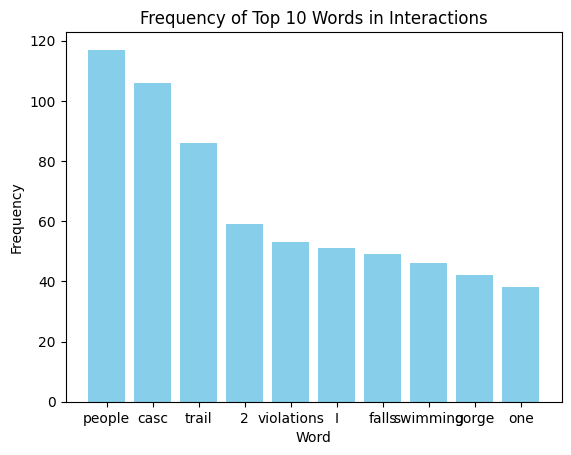

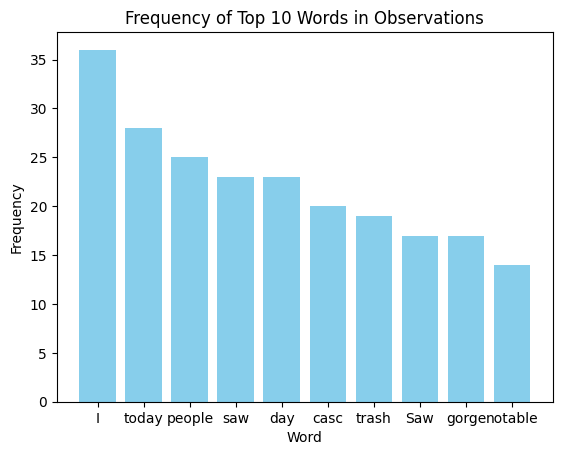

In [ ]:
# visualization of the frequency of words in interactions

data = inter_counter.most_common(10)
words, values = zip(*data)
plt.bar(words, values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Interactions')
plt.show()

data = obsv_counter.most_common(10)
words, values = zip(*data)
plt.bar(words, values, color='skyblue')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 10 Words in Observations')
plt.show()

*Also at that cool stuff from the previous paper*


## Sentiment Analysis

In [ ]:
# Score text sentiment
vader = SentimentIntensityAnalyzer()

# tokenizes text
def tokenize_text(text) :
    return [word_tokenize(sent.lower()) for sent in sent_tokenize(text)]

# method to return sentiment scores of a sentence
def text_sentiment(analyzer, tokens, vader_lexicon):
    sentiment_dict = analyzer.polarity_scores(' '.join(tokens))
    compound_score = sentiment_dict['compound']

    if compound_score >= 0.05:
        overall_sentiment = 'pos'
    elif compound_score <= -0.05:
        overall_sentiment = 'neg'
    else:
        overall_sentiment = 'neu'

    matched_terms = {}
    for token in tokens:
        token_lower = token.lower()
        if token_lower in vader_lexicon:
            matched_terms[token_lower] = vader_lexicon[token_lower]

    sentiment_dict['overall sentiment'] = overall_sentiment
    sentiment_dict['matched terms'] = matched_terms

    return sentiment_dict

def print_sentiment(sentiments_list):
  print("Total sentences:", len(sentiments_list))
  print("Total positive sentences:", sum([sent['overall sentiment'] == 'neg' for sent in sentiments_list]))
  print("Total neutral sentences:", sum([sent['overall sentiment'] == 'neu' for sent in sentiments_list]))
  print("Total negative sentences:", sum([sent['overall sentiment'] == 'pos' for sent in sentiments_list]))
  print("Average sentiment:", sum([sent['compound'] for sent in inter_sentiment]) / len(sentiments_list))

In [ ]:
# create a list of tokenized interactions
inter_tokens = []
for interaction in interactions:
  inter_tokens.extend(tokenize_text(interaction['msg']))

print(inter_tokens)
# we remove "lower" as it has a negative sentiment score and biased the overall sentiment
# inter_tokens = [(filter(lambda x: x != "lower", sentence)) for sentence in inter_tokens]
# We also remove empty messages
# inter_tokens = [list(filter(lambda x: x != "", sentence)) for sentence in inter_tokens]

inter_sentiment = [text_sentiment(vader, tokens, vader.lexicon) for tokens in inter_tokens]

print_sentiment(inter_sentiment)

print("\nSentences with three or more matched terms:")
# print the most matched terms
for sent in inter_sentiment:
    if len(sent['matched terms']) > 2:
        print(sent['overall sentiment'])
        print(sent['matched terms'])
        print('---')

[['someone', 'asked', 'about', 'north', 'campus'], ['lots', 'of', 'commencement', 'direction', 'questions'], ['few', 'people', 'suntanning', 'on', 'rocks', 'in', 'the', 'water'], ['lots', 'of', 'people', 'looking', 'for', 'arboretum', ',', 'three', 'dogs', 'off', 'leash', 'on', 'bebee', 'lake', 'trail', 'and', 'cascadilla', 'trail', '.'], ['2', 'people', 'past', 'trail', 'in', 'hemlock', 'gorge'], ['big', 'day', 'for', 'tourists', ',', 'small', 'day', 'for', 'violators'], ['1', 'dog', 'off', 'leash', 'on', 'upper', 'casc'], ['four', 'guys', 'taking', 'photos', 'in', 'lower', 'casc'], ['people', 'standing', 'in', 'the', 'water', 'near', 'falls', ',', 'people', 'on', 'other', 'side', 'of', 'fence', ',', 'people', 'sitting', 'in', 'water', 'near', 'falls'], ['not', 'many', 'people', 'put', 'and', 'about', 'today'], ['people', 'trying', 'to', 'swim', 'in', 'the', 'base', 'of', 'ithaca', 'falls', 'area', ',', 'child', 'leaning', 'over', 'the', 'edge', 'of', 'that', 'pool', 'part', ',', 'guy

In [ ]:
# create a list of tokenized observations
obsv_tokens = []
for observation in observations:
  obsv_tokens.extend(tokenize_text(observation['msg']))

# # we remove "lower" as it has a negative sentiment score and biased the overall sentiment
# obsv_tokens = [list(filter(lambda x: x != "lower", sentence)) for sentence in obsv_tokens]
# # We also remove empty messages
# obsv_tokens = [list(filter(lambda x: x != "", sentence)) for sentence in obsv_tokens]

obsv_sentiment = [text_sentiment(vader, token, vader.lexicon) for token in obsv_tokens]

print_sentiment(obsv_sentiment)

print("\nSentences with three or more matched terms:")
# print the most matched terms
for sent in obsv_sentiment:
    if len(sent['matched terms']) > 2:
        print(sent['overall sentiment'])
        print(sent['matched terms'])
        print('---')

Total sentences: 324
Total positive sentences: 40
Total neutral sentences: 211
Total negative sentences: 73
Average sentiment: -0.12974012345679017

Sentences with three or more matched terms:
neg
{'trouble': -1.7, 'violently': -2.8, 'threatened': -2.0}
---
pos
{'violations': -2.4, 'good': 1.9, 'nice': 1.8}
---
neg
{'surprised': 0.9, 'no': -1.2, 'violations': -2.4, 'number': 0.3, 'cool': 1.3}
---
pos
{'like': 1.5, 'great': 3.1, 'heron': 0.1}
---
pos
{'freaked': -1.2, 'hope': 1.9, 'okay': 0.9}
---
pos
{'nice': 1.8, 'great': 3.1, 'rainy': -0.3}
---
pos
{'love': 3.2, 'easily': 1.4, 'violators': -1.9}
---
pos
{'super': 2.9, 'rainy': -0.3, 'nice': 1.8, 'cool': 1.3}
---
pos
{'dead': -3.3, 'heroes': 2.3, 'save': 2.2}
---


In [ ]:
inter_sent_date = []
for sent in interactions:
  token_sent = tokenize_text(sent['msg'])
  token_sent = (map(str, token_sent))
  token_sent = ' '.join(token_sent)

  sentiment = text_sentiment(vader, token_sent, vader.lexicon)
  content = {
      'date': sent['date'],
      'sentiment': sentiment
  }
  inter_sent_date.append(content)

inter_sent_date = pd.DataFrame(inter_sent_date)
inter_sent_date.date = pd.to_datetime(inter_sent_date.date).dt.year

# Calculate the average sentiment of interactions for each year
for key, group in inter_sent_date.groupby(inter_sent_date.date):
  print("Year", key)
  print_sentiment(group['sentiment'])
  print("---")


Year 2011.0
Total sentences: 1
Total positive sentences: 0
Total neutral sentences: 1
Total negative sentences: 0
Average sentiment: -42.035800000000016
---
Year 2015.0
Total sentences: 26
Total positive sentences: 0
Total neutral sentences: 26
Total negative sentences: 0
Average sentiment: -1.616761538461539
---
Year 2016.0
Total sentences: 4
Total positive sentences: 0
Total neutral sentences: 4
Total negative sentences: 0
Average sentiment: -10.508950000000004
---
Year 2017.0
Total sentences: 1
Total positive sentences: 0
Total neutral sentences: 1
Total negative sentences: 0
Average sentiment: -42.035800000000016
---
Year 2019.0
Total sentences: 4
Total positive sentences: 0
Total neutral sentences: 4
Total negative sentences: 0
Average sentiment: -10.508950000000004
---
Year 2020.0
Total sentences: 30
Total positive sentences: 0
Total neutral sentences: 30
Total negative sentences: 0
Average sentiment: -1.401193333333334
---
Year 2021.0
Total sentences: 91
Total positive sentences

In [ ]:
# obsv_sent_date = []

# for sent in observations:
#   token_sent = tokenize_text(sent['msg'])
#   token_sent = (map(str, token_sent))
#   token_sent = ' '.join(token_sent)

#   sentiment = text_sentiment(vader, token_sent, vader.lexicon)
#   content = {
#       'date': sent['date'],
#       'sentiment': sentiment
#   }
#   obsv_sent_date.append(content)

#   obsv_sent_date = pd.DataFrame(obsv_sent_date)
#   obsv_sent_date.date = pd.to_datetime(obsv_sent_date.date).dt.year

#   # Calculate the average sentiment of interactions for each year
#   for key, group in obsv_sent_date.groupby(obsv_sent_date.date):
#     print("Year", key)
#     print_sentiment(group['sentiment'])
#     print("---")




## Euclidean Differences

In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', norm='l2', use_idf=False)

# extract out only the messages of log
inter_obsv_tokens = [inter_tokens, obsv_tokens]

# features = vectorizer.fit_transform(inter_obsv_tokens)
features = tfidf_vectorizer.fit_transform([str(x) for x in inter_obsv_tokens])


print('Matrix shape:', features.shape)
# print('Feature labels:', vectorizer.get_feature_names_out())
# print('Stopwords used:', vectorizer.stop_words_, '\n')
# print('First line vector:', features[0].toarray(), '\n')

# print('Unique words:', list(set(log[0].split())))

euclidean_dist = euclidean_distances(features)
cosine_dist = cosine_distances(features)

print("\nEuclidean Distances (Normalized, TF-IDF):")
print(euclidean_dist)
print("\nCosine Distances (Normalized, TF-IDF):")
print(cosine_dist)



Matrix shape: (2, 1396)

Euclidean Distances (Normalized, TF-IDF):
[[0.         0.52700126]
 [0.52700126 0.        ]]

Cosine Distances (Normalized, TF-IDF):
[[0.         0.13886516]
 [0.13886516 0.        ]]


Matrix Shape:

The TF-IDF matrix has a shape of (2, 1396), indicating that there are 2 documents and 1396 features (likely unique terms or words after processing the text data).
Euclidean Distances (Normalized, TF-IDF):

This matrix shows the normalized Euclidean distances between pairs of documents.
The values in the matrix represent how "far apart" the documents are in the multi-dimensional space of the TF-IDF features.
The diagonal elements are zero, as each document is identical to itself.
The off-diagonal elements indicate the normalized Euclidean distances between the two documents.
In this case, the Euclidean distance between the two documents is 0.52700126.
Cosine Distances (Normalized, TF-IDF):

This matrix displays the normalized cosine distances between pairs of documents.
The values in the matrix represent how dissimilar the documents are based on cosine similarity (1 - cosine similarity).
The diagonal elements are zero, as each document is perfectly similar to itself.
The off-diagonal elements indicate the normalized cosine distances between the two documents.
In this case, the cosine distance between the two documents is 0.13886516.
Interpretation:

A lower value in the Euclidean Distances matrix and a higher value in the Cosine Distances matrix suggest that the two documents are more similar.
The specific values themselves are relative, and their interpretation may depend on the range of values typically observed in your dataset.
The Euclidean distance is generally small, indicating proximity in the TF-IDF feature space.
The Cosine distance is also small, suggesting high similarity between the two documents.
In summary, these results indicate that the two documents are close in both Euclidean and cosine distances, signifying a high degree of similarity based on their TF-IDF representations.

In [ ]:
steward_log = inter_tokens
stweard_log = steward_log.extend(obsv_tokens)

print(len(steward_log))

print(steward_log[1])


1148
['lots', 'of', 'commencement', 'direction', 'questions']


## Unsupervised Clustering Labelling Types of Interactions




In [ ]:
def plot_compare(X, labels, title, alpha=0.2):
    '''
    Takes an array of object data, a list of cluster labels, a title string, and an optional alpha value.
    Reduces dimensions to 2 if necessary and plots the clustering with and without coloring by label.
    Returns nothing.
    '''
    if X.shape[1] > 2:
        svd = TruncatedSVD(n_components=2)
        X_reduced = svd.fit_transform(X)
    else:
        X_reduced = X

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], alpha=alpha)
    ax1.set_title('Unclustered Data')

    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', alpha=alpha)
    ax2.set_title('Clustered Data')

    fig.suptitle(title)

    plt.show()

    # Pull sample texts from each label set
def pull_samples(texts, labels, n=3):
    unique_labels = np.unique(labels)

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]

        print("Label:", label)
        print("Number of texts in this cluster:", len(label_indices))

        if len(label_indices) == 0:
            print("No texts in this cluster.")
        else:
            sampled_indices = np.random.choice(label_indices, size=min(n, len(label_indices)), replace=False)

            for i, index in enumerate(sampled_indices):
                print('\033[1m' + "Sample text", i + 1, "(Index:", index, "):" + '\033[0m', texts[index])

        print("----------------------------")

### Interactions

#### K-Means

Shape of clustered interactions: (354,)


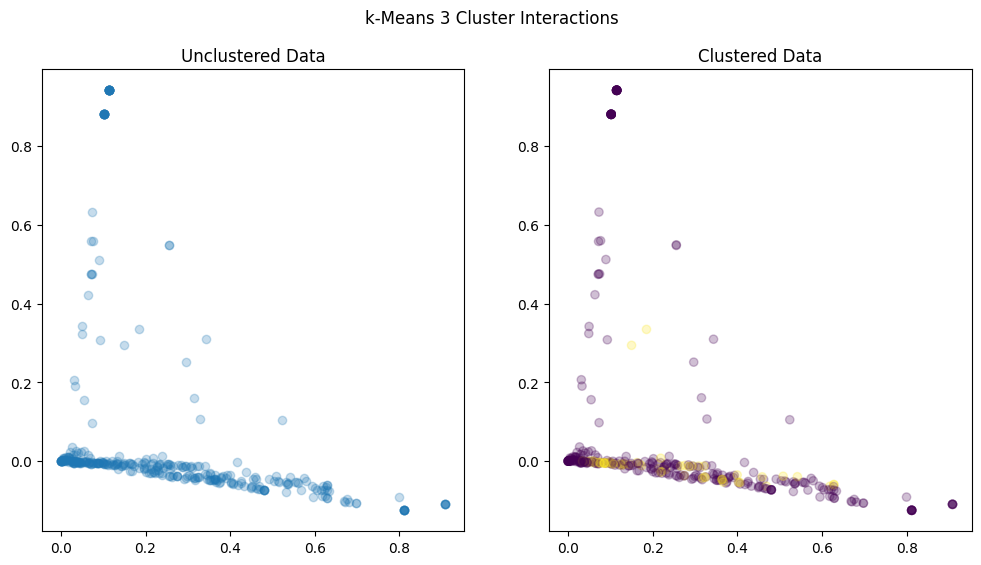

Label: 0
Number of texts in this cluster: 295
Sample text 1 (Index: 57 ): no one looking to break rules or chat today
Sample text 2 (Index: 179 ): People of trail in casc
Sample text 3 (Index: 175 ): pet some cute dogs on the trail
Sample text 4 (Index: 341 ): there's a dug up root in lower Casc, right next to the trail across from the small island
Sample text 5 (Index: 37 ): Man (mask, no shirt) informed me (shirt, no mask) that there was an air quality warning
----------------------------
Label: 1
Number of texts in this cluster: 59
Sample text 1 (Index: 204 ): 2 people below suspension bridge above horseshoe falls, 3 people on Cascadilla Gorge trail closed section
Sample text 2 (Index: 283 ): 1) Trail from south end of Beebe to Nevin Welcome Center becoming overgrown with beech. 2) Culvert under trail blocked and trail erroded. North side of Cascadilla under Rhodes Hall.
Sample text 3 (Index: 348 ): dumbbell in lower Cascadilla (?)
Sample text 4 (Index: 196 ): 4 jumping the cascadil

In [ ]:
# k-Means clustering with n_clusters = 2
inter = []
for interaction in interactions:
  inter.append(interaction['msg'])

inter_tokens = tfidf_vectorizer.fit_transform(inter)


inter_pred_2 = KMeans(n_clusters=2, n_init='auto').fit_predict(inter_tokens)
print("Shape of clustered interactions:", inter_pred_2.shape)
plot_compare(inter_tokens, inter_pred_2, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(inter, inter_pred_2, 5)

Cluster 1: No violations
Cluster 2: Yes Violations

Shape of clustered interactions: (354,)


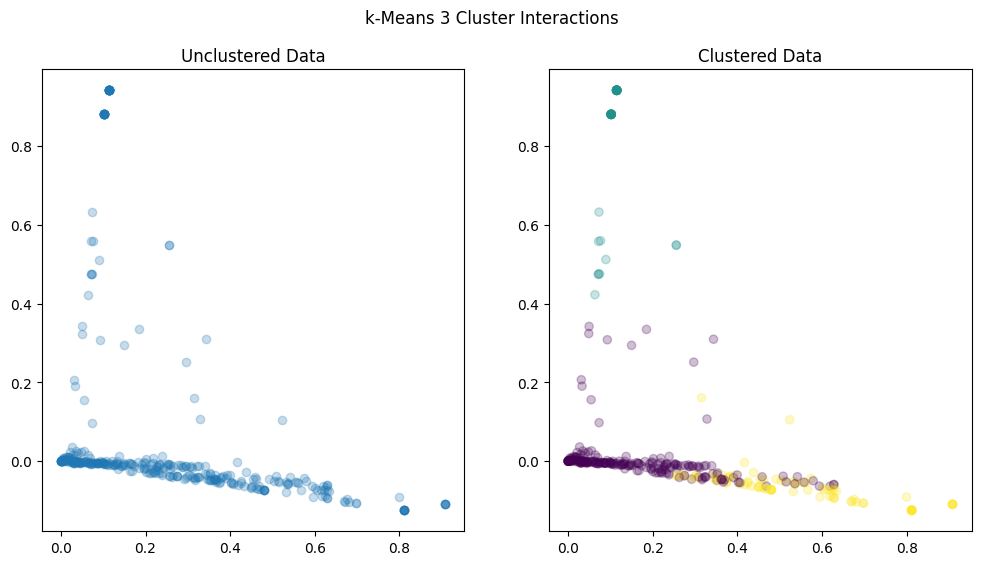

Label: 0
Number of texts in this cluster: 223
Sample text 1 (Index: 86 ): Two people swimming in the hemlock gorge area but happily left when asked
Sample text 2 (Index: 25 ): 2 children under the rocks on Cascadilla
Sample text 3 (Index: 323 ): Stewardship activities conducted (type and location)
Sample text 4 (Index: 69 ): People asked how to get to botanic gardens when I was near beebe
Sample text 5 (Index: 49 ): gave someone directions to beebe lake
----------------------------
Label: 1
Number of texts in this cluster: 44
Sample text 1 (Index: 245 ): No violations. Gave several families directions.; Weather was a bit too cold for the violators today
Sample text 2 (Index: 280 ): no violations
Sample text 3 (Index: 233 ): No violations. Water was high again today. No one in their right mind would jump in there...
Sample text 4 (Index: 271 ): no violations
Sample text 5 (Index: 259 ): No violations today
----------------------------
Label: 2
Number of texts in this cluster: 87
Sample 

In [ ]:
# k-Means clustering with n_clusters = 3
inter = []
for interaction in interactions:
  inter.append(interaction['msg'])

inter_vectors = tfidf_vectorizer.fit_transform(inter)


inter_pred_3 = KMeans(n_clusters=3, n_init='auto').fit_predict(inter_vectors)
print("Shape of clustered interactions:", inter_pred_3.shape)
plot_compare(inter_tokens, inter_pred_3, "k-Means 3 Cluster Interactions", alpha = 0.25)

pull_samples(inter, inter_pred_3, 5)

Cluster 1: No violations
Cluster 2:ones with "all"
CLuster 3: Other

#### Spectral Clustering

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral Clustering Labels Shape: (354,)


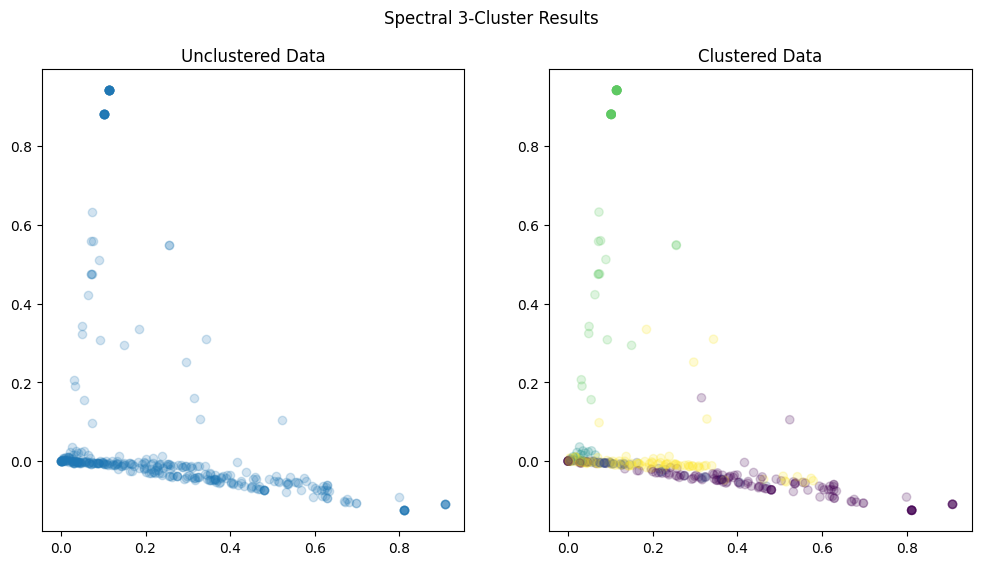

Label: 0
Number of texts in this cluster: 135
Sample text 1 (Index: 103 ): All minor instances of off trail, mostly in casc, 1 in fall creek where the guy was confused about the map he'd seen
Sample text 2 (Index: 46 ): All people in restricted casc areas
Sample text 3 (Index: 154 ): all people off trail in casc :)
Sample text 4 (Index: 42 ): It started pouring by the time I got to casc, mostly people hurrying out at that point
Sample text 5 (Index: 110 ): All people walking on rocks in casc for photo shoot. Still mostly reunion visitors
Sample text 6 (Index: 97 ): 3 people swimming in casc, one kid running around and swimming in casc, 4 people swimming in casc, one guy asked me if swimming was allowed in casc and I told him alternative options, 10 people drinking and swimming at the swimming hole upstream of the tennis courts, one dude fishing at hemlock gorge
Sample text 7 (Index: 177 ): dogs of leash in casc
Sample text 8 (Index: 173 ): a group of trail in casc
Sample text 9 (Index:

In [ ]:
spectral_clustering_3 = SpectralClustering(n_clusters=5, affinity='precomputed')

cosine_similarity_matrix = cosine_similarity(inter_vectors)

inter_spectral_3 = spectral_clustering_3.fit_predict(cosine_similarity_matrix)

print("Spectral Clustering Labels Shape:", inter_spectral_3.shape)

plot_compare(inter_vectors, inter_spectral_3, "Spectral 3-Cluster Results")

pull_samples(inter, inter_spectral_3, n=10)

Cluster 1: containing "all"
Cluster 2: Misc
Cluster 3: in casc
Cluster 4: no violations
Cluster 5: misc

#### DBSCAN

HDBSCAN Clustering Labels Shape: (354,)


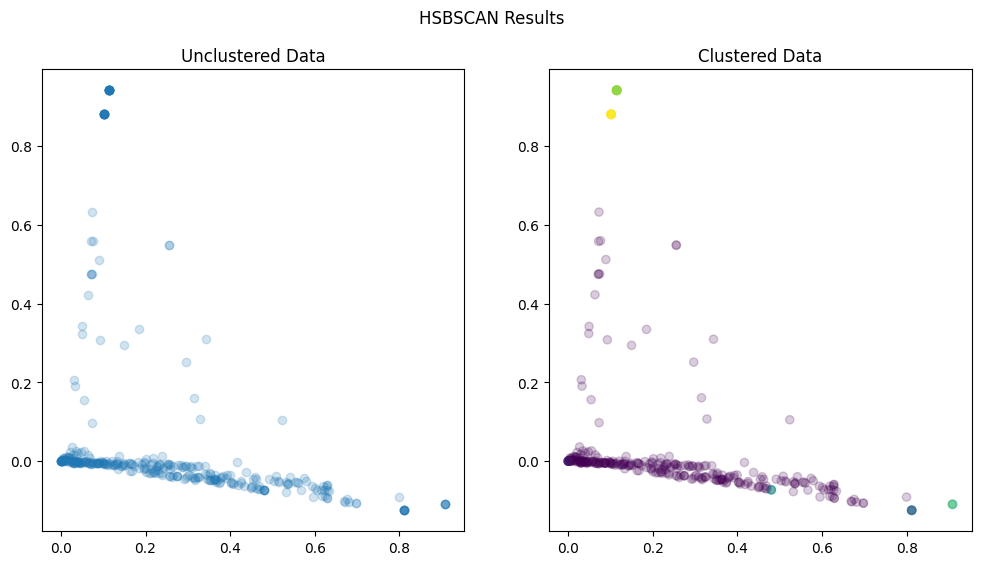

Label: -1
Number of texts in this cluster: 294
Sample text 1 (Index: 252 ): Two people and an unleashed dog under the Thurston Ave. bridge
Sample text 2 (Index: 13 ): fly fisher in Fall Creek (by Risley); dipping toes in prohibited part of casc; 2 swimmers in beebe; 3 people under suspension bridge
Sample text 3 (Index: 98 ): Most violations swimming/wading in casc, or animals off leash. 5 people wading in fall creek below the picnic area, left without issue once asked to leave, 4 swimming near ezra's tunnel and took so long to leave CUPD got called but left moments before they arrived. Saw a rock fall in hemlock gorge
Sample text 4 (Index: 191 ): 8 Swimmers upper cascadilla, 3 under lower cascadilla falls, 1 dog off leash
Sample text 5 (Index: 133 ): off trails in casc; some mom asked me to explain to their kid why they couldn't swim in casc
----------------------------
Label: 0
Number of texts in this cluster: 8
Sample text 1 (Index: 22 ): none
Sample text 2 (Index: 345 ): N.A
Sample

In [ ]:
inter_hdv_pred = DBSCAN().fit_predict(inter_vectors.toarray())

print("HDBSCAN Clustering Labels Shape:", inter_hdv_pred.shape)

plot_compare(inter_vectors, inter_hdv_pred, "HSBSCAN Results")

pull_samples(inter, inter_hdv_pred, n=5)


### Observations

K-Means

Shape of clustered interactions: (223,)


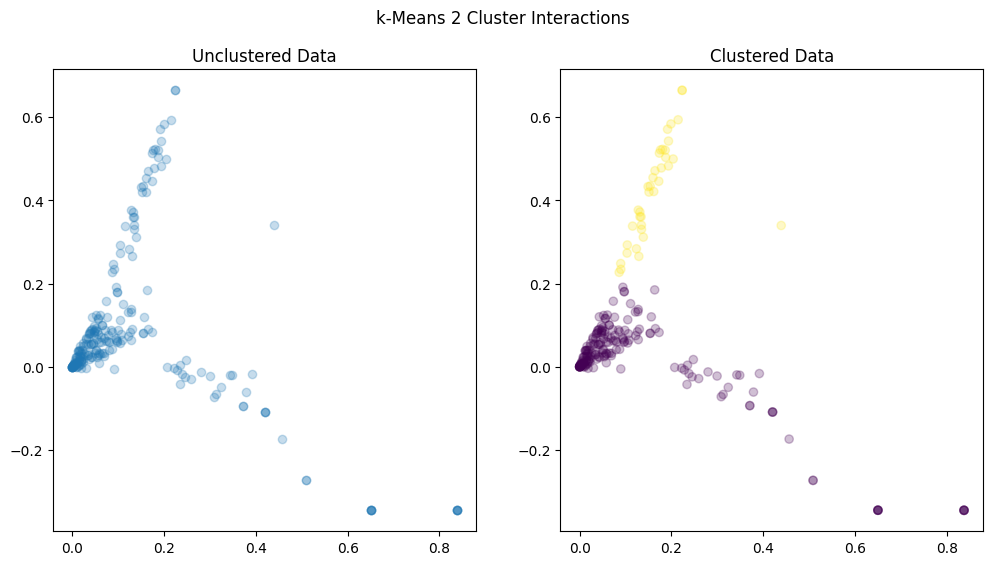

Label: 0
Number of texts in this cluster: 186
Sample text 1 (Index: 191 ): Left for lunch as the heavy thunderstorms rolled in, ended up heading for home since the rain continued through the rest of the shift
Sample text 2 (Index: 96 ): great blue heron in fall creek
Sample text 3 (Index: 16 ): Goose hissed at me and gave me the stink eye
Sample text 4 (Index: 8 ): ducklings at Cas. Gorge
Sample text 5 (Index: 53 ): last shift!
----------------------------
Label: 1
Number of texts in this cluster: 37
Sample text 1 (Index: 44 ): I saw a deer near hemlock gorge. Have a love hate relationship with deer
Sample text 2 (Index: 211 ): Animals ruled the day. I saw a pet pig on the suspension bridge. Also saw deer, groundhogs, and a fox! 
Sample text 3 (Index: 200 ): Saw a dead snake :(
Sample text 4 (Index: 41 ): saw the groundhog(s?) many times today
Sample text 5 (Index: 65 ): I saw a cool butterfly loafing around upper casc
----------------------------


In [ ]:
# k-Means clustering with n_clusters = 2
obsv = []
for observation in observations:
  obsv.append(observation['msg'])

obsv_vectors = tfidf_vectorizer.fit_transform(obsv)

obsv_pred_2 = KMeans(n_clusters=2, n_init='auto').fit_predict(obsv_vectors)
print("Shape of clustered interactions:", obsv_pred_2.shape)
plot_compare(obsv_vectors, obsv_pred_2, "k-Means 2 Cluster Interactions", alpha = 0.25)

pull_samples(obsv, obsv_pred_2, 5)

HDBSCAN Clustering Labels Shape: (223,)


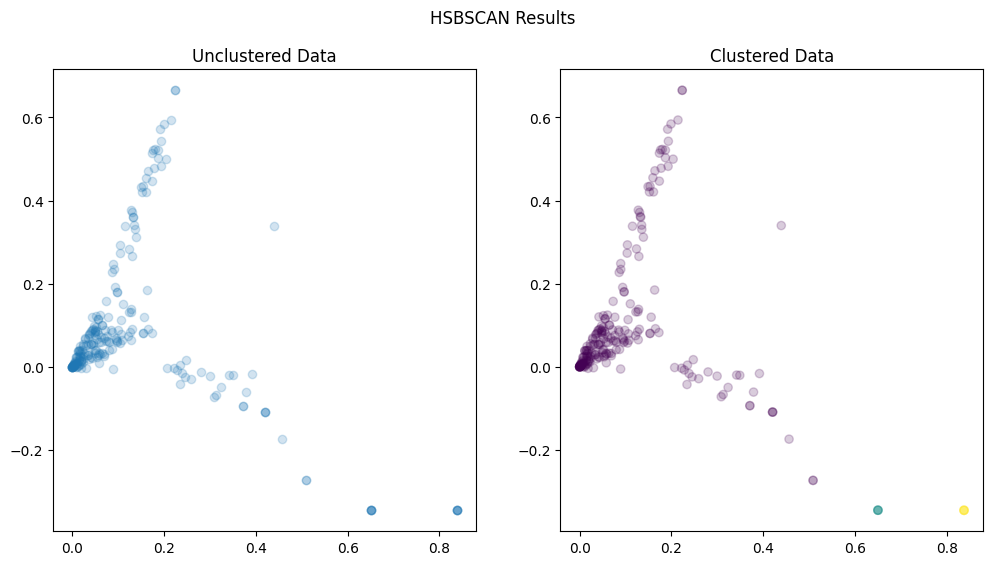

Label: -1
Number of texts in this cluster: 213
Sample text 1 (Index: 154 ): Water was very high today. Had those two gone in, they'd have gone right over the falls! Moved a whole lot of rocks that fell in cascadilla.
Sample text 2 (Index: 68 ): Surveyers taking scans of casc gorge wall in morning for future retaining wall. Gate down into fall creek now open
Sample text 3 (Index: 210 ): I think college students are returning by the masses!
Sample text 4 (Index: 17 ): Decided to hike instead of bike and the earth decided that would be a great time ot start thunderstorming.
Sample text 5 (Index: 33 ): air got worse throughout the day
----------------------------
Label: 0
Number of texts in this cluster: 5
Sample text 1 (Index: 178 ): Nothing notable.
Sample text 2 (Index: 203 ): Nothing notable.
Sample text 3 (Index: 175 ): Nothing notable.
Sample text 4 (Index: 197 ): Nothing notable.
Sample text 5 (Index: 194 ): Nothing notable.
----------------------------
Label: 1
Number of texts in t

In [ ]:
obsv_hdv_pred = DBSCAN().fit_predict(obsv_vectors.toarray())

print("HDBSCAN Clustering Labels Shape:", obsv_hdv_pred.shape)

plot_compare(obsv_vectors, obsv_hdv_pred, "HSBSCAN Results")

pull_samples(obsv, obsv_hdv_pred, n=5)


## Classification

In [ ]:
inter_tokenized = []
for inter in interactions:
  inter_tokenized.append(nltk.word_tokenize(inter['msg']))

violation_labels = ['no violation', 'casc', 'other']

steward_labels = []
for interaction in interactions:
  steward = interaction['steward']
  if steward not in steward_labels:
    steward_labels.append(steward)

year_labels = []
for interaction in interactions:
  year = str(interaction['date']).split('-')[0]
  if year not in year_labels:
    year_labels.append(year)

In [ ]:
# Plot the feature data
data_reduced = TruncatedSVD(n_components=3).fit_transform(inter_tokenized)
# print(data_reduced)

for i, violation in enumerate(np.unique(violation_labels)):
    plt.scatter(data_reduced[violation_labels == violation, 0],
                data_reduced[violation_labels == violation, 1],
                # data_reduced[violation_labels == violation, 2],
                label=violation)

plt.title("Truncated SVD of Feature Data (3-Dim), by violation type")
plt.legend()

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_array_api.py:185: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = numpy.asarray(array, order=order, dtype=dtype)


ValueError: ignored